# Big Data Project
Il progetto consiste dei tizi caio e caio e caio per la predizione delle frodi bla bla di credito bla bla.
Ambiente: si è voluto usare bla bla, HDFS, Spark e Pandas.

## 1.Inizializzazione dell'ambiente Spark
L'inizializzazione dell'ambiente Spark consiste nell'importazione dei relativi moduli e dell'inizializzazione di una nuova SparkSession.

PySpark isn't on sys.path by default, but that doesn't mean it can't be used as a regular library. You can address this by either symlinking pyspark into your site-packages, or adding pyspark to sys.path at runtime. findspark does the latter.
Without any arguments, the SPARK_HOME environment variable will be used, and if that isn't set, other possible install locations will be checked. If you've installed spark with

In [ ]:
import findspark

location = findspark.find()
findspark.init(location)

from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession.builder \
    .appName("Progetto BigData Gatto - Lavalle - Ferdico A.A. 2020/2021") \
    .getOrCreate()

## Descrizione del dataset

Il dataset analizzato nel progetto è un insieme di record di transazioni di carte di credito a cui è stato effettuato una PCA. I dati sono raccolti in maniera continua da (@TODO MESE ANNO). Il dataset analizzato presenta circa (@TODO) di record di incidenti al momento dell'analisi in questo progetto.

Il dataset è fornito in formato .csv. La tabella seguente ne descrive tutti gli attributi:

## TABELLA DATASET CON SPIEGAZIONE DELLE COLONNE

## Importazione del dataset in HDFS

COMANDO CLI PER IL CARICAMENTO DEL FILE .CSV IN HDFS

In [ ]:
hdfs fs -put nomeFileLocale DirectoryDestinazione

## Lettura del dataset da HDFS con Spark

Il codice seguente permette la lettura del file da HDFS e quindi l'importazione del dataset in formato .csv all'interno del dataframe secondo lo schema appena creato.

In [ ]:
dataSet = spark.read \
    .csv('hdfs://localhost:9099/creditCardProject/creditcard.csv', header = 'True', inferSchema='True')

# 3. Dataset preprocessing
La fase di preprocessing è necessaria per preparare il dataset appena caricato prima dell'analisi vera e propria. I dati presenti possono infatti presentare errori, dati mancanti o valori non previsti. L'obiettivo del preprocessing è quindi quello di pulire tali informazioni rimuovendo o "curando" i dati che presentano rumore o qualsiasi altro tipo di inconsistenze.

# GRAFICI

## 3.1 Data cleaning
Banalmente, la prima operazione può essere quella di individuare le informazioni che presentano caratteristiche con valori mancanti. Il trattamento di valori mancanti può avvenire fondamentalmente in due modi: cancellazione o imputazione. La scelta corretta dipende dall'obiettivo dell'analisi e dalla possibile conoscenza a priori del problema, oltre ovviamente che dalle quantità di tali valori nulli.

In [ ]:
nullValues = dataSet.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dataSet.columns])
nullValues.show()

Dall'esecuzione precedente è possibile notare come tutte le features presenti nel dataset non presentino dati mancanti.
Una piccola parentesi va invece aperta per l'analisi predittiva. Ricordando che è richiesta la previsione della classe di appartenza di una transazione, le caratteristiche che possono in qualche modo influenzare questo campo andranno sicuramente mantenute. Le operazioni successive andranno ad identificare le feature meno rilevanti e che andremo ad eliminare.

Convertiamo in Pandas per una gestione più semplice per poter fare i grafici

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt

df = dataSet.toPandas()

Grafico X: Amount --> Y: Class

In [ ]:
X = df['Amount']
Y = df['Class']

plt.style.use('seaborn-whitegrid')
plt.xlabel("Amount")
plt.ylabel("Class")
plt.scatter(X, Y, marker = ".", color = 'red')
plt.show()

È possibile dedurre che il dataset è sbilanciato e che le transazioni con class = 1 (frodi) hanno un valore di Amount relativamente basso (< 5000).

Grafico: X: Time -- Y:Amount (Rosso frode - Blu non frode)

In [ ]:
#Grafico non frode
xlim = df['Time'].max() * 1.2
ylim = df['Amount'].max() * 1.2

X = np.where(df['Class']==0, df['Time'], None)
Y = np.where(df['Class']==0, df['Amount'], None)

plt.style.use('seaborn-whitegrid')
plt.xlabel("Time")
plt.ylabel("Amount")
plt.scatter(X, Y, marker = ".", color = "blue")

X = np.where(df['Class']==1, df['Time'], None)
Y = np.where(df['Class']==1, df['Amount'], None)
plt.scatter(X, Y, marker = ".", color = "red")

# Eliminazione delle features meno rilevanti

## Matrice di correlazione

In [ ]:
import seaborn as sns

# shuffle before creating subsamples

df_fraud = df.loc[df.Class == 1]
df_non_fraud = df.loc[df.Class == 0][1000:1492]

dfFifty = pd.concat([df_fraud, df_non_fraud])

plt.figure(figsize=(12, 10))
corr = dfFifty.corr()
corr = pd.DataFrame.abs(corr)
fig = sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})
fig.set_title('Correlation Matrix', fontsize=14)
plt.show()

soglia = 0.05
print(corr["Class"] < soglia)

Dalla matrice di correlazione eliminiamo questo, questo e questo

## Fisher Score

In [ ]:
from skfeature.function.similarity_based import fisher_score

df_fraud = df.loc[df.Class == 1]
df_non_fraud = df.loc[df.Class == 0][0:492]

dfFifty = pd.concat([df_fraud, df_non_fraud])

fisherX = np.array(dfFifty.iloc[:, dfFifty.columns != 'Class'])
fisherY = np.array(dfFifty.iloc[:, dfFifty.columns == 'Class'])
fisherY = fisherY.reshape(1, -1)[0]

idx = fisher_score.fisher_score(fisherX, fisherY) #returns rank directly instead of fisher score. so no need for feature_ranking
idx = fisher_score.feature_ranking(idx)
print(idx)

Dal fisher score eliminiamo questo, questo e questo

## 3.2 Salvataggio del dataset cleaned_accidents_dataset.csv
E' sicuramente conveniente salvare direttamente nel Drive personale il dataset così ottenuto per non ripetere i passaggi di data cleaning appena descritti ad ogni nuovo accesso a Colab. Per memorizzare il cleaned dataset, è possibile semplicemente utilizzare il metodo .write() fornito da Spark.

## 4. Importazione del cleaned dataset
cleaned_accidents_dataset.csv
Andiamo quindi ad importare il nuovo dataset cleaned_accidents_dataset.csv . Per farlo è necessario costruire nuovamente lo schema del dataframe che ospiterà il dataset e infine utilizzare il metodo read di Spark.

Divisione del dataset in training set e validation set

### 6. Analisi predittiva
Per il progetto è anche richiesto lo svolgimento dell'analisi predittiva della severità dell’evento incidente sulla base del campo Severity . Il campo Severity indica la gravità di un incidente e l'impatto sul traffico ad esso correlato classificandolo in una di quattro possibili classi con le etichette da 1 a 4 (da minimo impatto sul traffico a massimo impatto). E' chiaro che essendo tali classi etichettate con dei valori finiti, sia possibile una loro predizione attraverso l'utilizzo di un classificatore.

#### 6.1 Preliminari analisi predittiva
Il primo passaggio per l'analisi predittiva è ovviamente l'importazione di tutte le librerie di Machine Learning dedicate alla creazione di un modello predittivo.

### 6.4 Scelta delle features
Più paragrafi sono stati dedicati alla pulizia del dataset, alla scelta delle features e quindi alla rimozione delle caratteristiche con dati mancanti o palesemente non necessari all'analisi. Per l'analisi predittiva ciò non basta,infatti alcune delle features possono essere in qualche modo implicitamente correlate al campo Severity , e per tale motivo utili alla sua predizione. Un possibile modo per individuare le features correlate è quello di utilizzare l'approccio statistico.
Calcolare le correlazioni tra la caratteristica Severity ed il resto è possibile calcolando la relativa matrice di correlazione. E' chiaro quindi che vanno escluse tutte le caratteristiche aventi una correlazione col campo preso in esame al di sotto di una certa soglia.
Per poter carcolare la matrice di correlazione, è possibile utilizzare un metodo fornito da Pandas. E' quindi necessario importare il dataset indicizzato all'interno di un suo dataframe:

Dalla matrice di correlazione appena ottenuta, va presa in considerazione soltanto la prima colonna ovvero quella relativa alle correlazioni tra la caratteristica Severity e ognuna delle altre caratteristiche.
Tanto è maggiore in valore assoluto la correlazione tra due variabili aleatorie, tanto più la conoscenza del valore di una è utile a prevedere il valore dell'altra. Per tale motivo è necessario calcolare i valori assoluti delle correlazioni tra
Severity e le altre caratteristiche, ed infine ordinarli in ordine decrescente:

6.8 Bilanciamento delle classi di Severity
Prima di continuare è necessario anche analizzare il bilanciamento delle classi appartenenti alla caratteristica Severity :

Il risulta mostra un bilanciamento non proprio uniforme. In particolare è possibile notare come la classe 1 e 4 sono quelle meno frequenti rispetto alle altre presenti. E' possibile bilanciare la distribuzione di tali classi attraverso l'oversampling. L'oversampling consiste nella duplicazione dei record delle le classi meno frequenti. Di conseguenza, va utilizzato il metodo .sample fornito sempre da Spark. Il metodo appena citato permette di specificare una frazione di record da estrarre dal dataframe da cui estrarre i campioni, con o senza sostituzione. L'oversampling sarà effettuato esclusivamente del training set per non influenzare i risultati della predizione da parte del modello.
Visuliazziamo la distribuzione delle classi per la stessa caratteristica ma soltanto per il Training Set:

Proviamo quindi a distribuire in maniera più uniforme tali classi tramite oversampling. E' evidente che l'oversampling debba essere seguito sui record aventi classi 1 , 3 e 4 di Severity .
Bisogna innanzitutto separare i record appartenenti alle stesse classe di Severity:

Come descritto prima, è necessario l'oversampling sui record appartenenti alle classi 1 , 3 e 4 . Il fattore di oversampling è gestibile tramite il parametro fraction di sample .

Controlliamo quindi se la distribuzione delle classi all'interno del dataset si è uniformata:

Valutazione dell'errore del modello ottenuto al passo precedente

In [ ]:
dfFinal = df.drop(["Time", "V3", "V6", "V11", "V14"], axis = 1) # <-- dal fisher score
dfFinal = dfFinal.drop(["V13", "V23"], axis = 1) # <-- dalla matrice di correlazione

from sklearn import preprocessing

standardScaler = preprocessing.StandardScaler()
scaledTime = standardScaler.fit_transform(X = dfFinal[['Time']])
scaledAmount = standardScaler.fit_transform(X = dfFinal[['Amount']])

dfFinal['ScaledTime'] = scaledTime
dfFinal['ScaledAmount'] = scaledAmount

dfFinal = dfFinal.drop(['Time', 'Amount', 'ScaledTime'], axis = 1)

X = dfFinal.iloc[:, dfFinal.columns != 'Class']
y = dfFinal.iloc[:, dfFinal.columns == 'Class']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.3, random_state = 50)

from sklearn.metrics import recall_score
from sklearn.neural_network import MLPClassifier

#hidden_layer_sizes=(200,)
MLPC = MLPClassifier(hidden_layer_sizes=(200,6), max_iter=10000, verbose=True)
MLPC.fit(X_train, y_train.values.ravel())
y_pred = MLPC.predict(X_test)
# Obtenemos valores de recall
recall_acc = recall_score(y_test, y_pred)
print(recall_acc)
print(MLPC.score(X_test, y_test))

In [ ]:
#F1 score
from sklearn.metrics import f1_score
f1result = f1_score(y_test, y_pred)
print(f1result)

6.9 Training
Per l'addestramento è necessario importare i modelli da addestrare dalle librerie di Spark per la classificazione. Come modelli verranno utilizzati Decision Tree ed il classificatore di tipo probabilistico Naive Bayes per poter confrontare infine i risultati ottenuti.
Per poter inizializzare i modelli è necessario prima inserire come parametri la caratteristica che il modello deve predire Severity , e la colonna delle features .


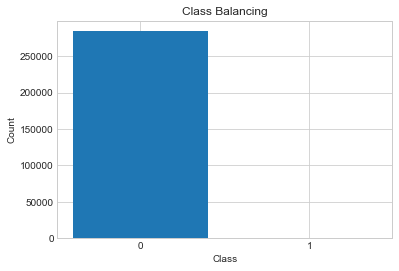

In [15]:
dfFinal = df.drop(["Time", "V3", "V6", "V11", "V14"], axis = 1) # <-- dal fisher score
dfFinal = dfFinal.drop(["V13", "V23"], axis = 1) # <-- dalla matrice di correlazione

#Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

features = dfFinal[dfFinal.columns[:len(dfFinal.columns)-1]].to_numpy()
targets = dfFinal.Class.to_numpy()
#features, targets = SMOTE().fit_resample(features,targets)
#targets = targets.reshape(-1,1)

target_un,count = np.unique(targets,return_counts=True)
plt.title("Class Balancing")
plt.xlabel("Class")
plt.ylabel("Count")
plt.bar([str(i) for i in target_un],count)
plt.show()



In [16]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(features, targets, test_size=0.3, shuffle=True)

print("Train Feature size : ", len(X_train))
print("Train Label size   :", len(Y_train))
print("Test Feature size  :", len(X_test))
print("Test Label size    :", len(Y_test))

#SOVRACAMPIONAMENTO SOLO DEL TRAINING SET IN MODO DA SBAGLIARE SOLO 1 VOLTA E NON N VOLTE NEL TEST SET
X_train, Y_train = SMOTE().fit_resample(X_train,Y_train)
Y_train = Y_train.reshape(-1,1)

Train Feature size :  199364
Train Label size   : 199364
Test Feature size  : 85443
Test Label size    : 85443


In [ ]:
model = RandomForestClassifier(n_estimators=100, criterion="entropy")
model.fit(X_train, Y_train)

In [ ]:
trainPredetto = model.predict(X_train)
testPredetto = model.predict(X_test)

cm = confusion_matrix(Y_test, testPredetto, labels=[0, 1])

cmatrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non Frode","Frode"])
cmatrix.plot()
plt.title("Matrice di Confusione")
plt.show()

veriNegativi = cm[0][0]
veriPositivi = cm[1][1]
falsiPositivi = cm[0][1]
falsiNegativi = cm[1][0]

nonFrodiTotali = veriNegativi + falsiPositivi
frodiTotali = veriPositivi + falsiNegativi

percentualeDiSuccessoNonFrodi = veriNegativi / nonFrodiTotali
percentualeDiSuccessoFrodi = veriPositivi / frodiTotali

print("Train score     : {:.2f} %".format(accuracy_score(trainPredetto, Y_train) * 100))
print("Test score      : {:.2f} %".format(accuracy_score(testPredetto, Y_test) * 100))
print("Accuratezza riconoscimento frodi : {:.2f} %".format(percentualeDiSuccessoFrodi*100))
print("Accuratezza riconoscimento non frodi : {:.2f} %".format(percentualeDiSuccessoNonFrodi*100))

from sklearn.metrics import recall_score
print("Recall score sul test set     : {:.2f} %".format(recall_score(testPredetto, Y_test) * 100))

### 6.10 Prediction e valutazione dei modelli
Ora che i modelli sono stati addestrati, è finalmente possibile iniziare la predizione di Severity utilizzando il test set. Di conseguenza, viene utilizzato il metodo .transform() che restituisce direttamente il dataframe contenente la predizione dei modelli utilizzati e la relativa label corretta.
Per la valutazione dei modelli appena addestrati, vengono utilizzate le metriche fornite dalle librerie Scikit-learn , ovvero librerie di machine learning open-source scritte in Python.
Tutte le metriche fornite dalle librerie da Scikit-learn utilizzano come parametri di input y_true e y_pred . Queste rappresentano rispettivamente le label verità e le label predette dal classificatore. Tali parametri possono essere prelevati direttamente dai dataframe ottenuti nel passaggio precedente:

### 6.10.1 Accuracy
L'accuratezza è semplicemente la percentuale delle istanze classificate correttamente. Calcoliamo quindi l'accuracy dei modelli addestrati:

### 6.10.2 Balanced Accuracy
Nei casi in cui il dataset non sia bilanciato nel migliore dei modi, come nel nostro caso, ha senso anche la valutazione della balanced accuracy che calcola la media aritmetica delle accuratezze specifiche delle classi:

### 6.10.3 F1 Micro
Valutazione della F1 micro dei modelli addestrati:

### 6.10.4 F1 Macro
Valutazione della F1 macro dei modelli addestrati:

In [ ]:
print(frodiTotali + nonFrodiTotali)